<img src="https://cdn.siberian.dev/siberian.png" alt="Siberian Logo">

### Simple Exponential Smoothing

This code template is for Time Series Analysis and Forecasting with the help of Exponential Smoothing. Exponential smoothing is a time series forecasting method for univariate data that can be extended to support data with a systematic trend or seasonal component. It is a powerful forecasting method as an alternative to the popular Box-Jenkins ARIMA family of methods.

### Required Packages

In [4]:
import warnings 
import numpy as np
import pandas as pd 
import seaborn as se 
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error 

warnings.filterwarnings("ignore")


### Initialization

Filepath of CSV file

In [1]:
file_path = ""

Variable containing the date time column name of the Time Series data

In [5]:
date = ""

Target feature for prediction.

In [6]:
target = ""

### Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [7]:
df = pd.read_csv(file_path)
df.head()

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151


### Data Preprocessing

Since the majority of the machine learning models for Time Series Forecasting doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippets have functions, which removes the rows containing null value if any exists. And convert the string classes date column in the datasets to proper Date-time classes.

After the proper date conversions are done and null values are dropped, we set the Date column as the index value.


In [8]:
def data_preprocess(df, target, date):
    df = df.dropna(axis=0, how = 'any')
    df[date] = pd.to_datetime(df[date])
    df = df.set_index(date)
    return df

In [9]:
df = data_preprocess(df,target,date)
df.head()

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


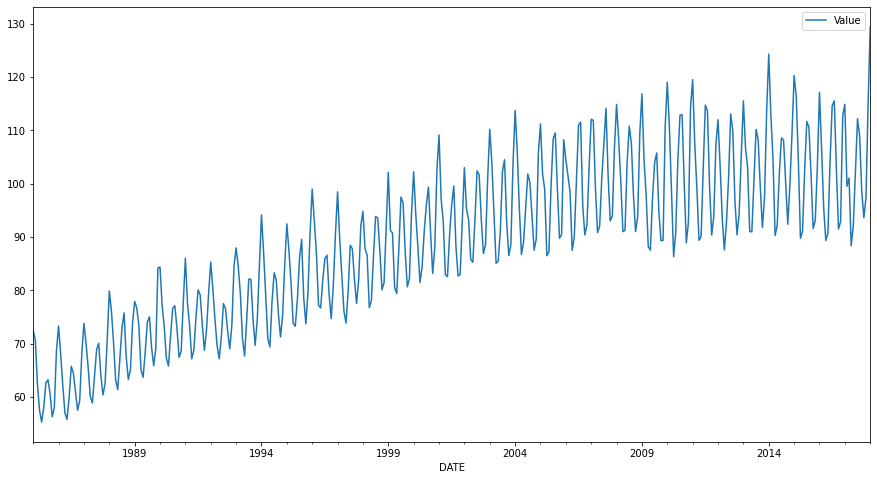

In [10]:
df.plot(figsize = (15,8))
plt.show()

### Seasonality decomposition

Since Simple Exponential Smoothing for non-seasonal data, we need to check for any seasonality in our time series and decompose it.

We use the Dickey Fuller Test for testing the seasonality and if the ADF Statistic value is positive, it means that the data has seasonality.

#### Dickey Fuller Test
The Dickey Fuller test is a common statistical test used to test whether a given Time series is stationary or not. The Augmented Dickey Fuller (ADF) test expands the Dickey-Fuller test equation to include high order regressive process in the model. We can implement the ADF test via the **adfuller()** function. It returns the following outputs:

    1. adf : float
> The test statistic.

    2. pvalue : float
> MacKinnon's approximate p-value based on MacKinnon(1994, 2010). It is used alongwith the test statistic to reject or accept the null hypothesis.

    3. usedlag : int
> Number of lags considered for the test

    4. critical values : dict
> Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010).

For more information on the adfuller() function [click here](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html)

In [ ]:
def dickeyFuller(df,target):
    
    # Applying Dickey Fuller Test
    X = df.values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Number of lags used: %d' % result[2])
    print('Critical Values:')
    for key, value in result[4].items():
           print('\t%s: %.3f' % (key, value))
    
    
    # Decomposing Seasonality if it exists
    if result[0]>0:
        df[target] = df[target].rolling(12).mean()
    
    return df

To remove the seasonality we use the rolling mean technique for smoothing our data and decomposing any seasonality.
This method provides rolling windows over the data. On the resulting windows, we can perform calculations using a statistical function (in this case the mean) in order to decompose the seasonality.

For more information about rolling function [click here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html)

In [ ]:
df = dickeyFuller(df,target)

ADF Statistic: -2.256990
p-value: 0.186215
Number of lags used: 15
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


### Autocorrelation Plot


We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.
A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. 

An autocorrelation plot shows whether the elements of a time series are positively correlated, negatively correlated, or independent of each other. 
The plot shows the value of the autocorrelation function (acf) on the vertical axis ranging from –1 to 1.
There are vertical lines (a “spike) corresponding to each lag and the height of each spike shows the value of the autocorrelation function for the lag.

[API](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)

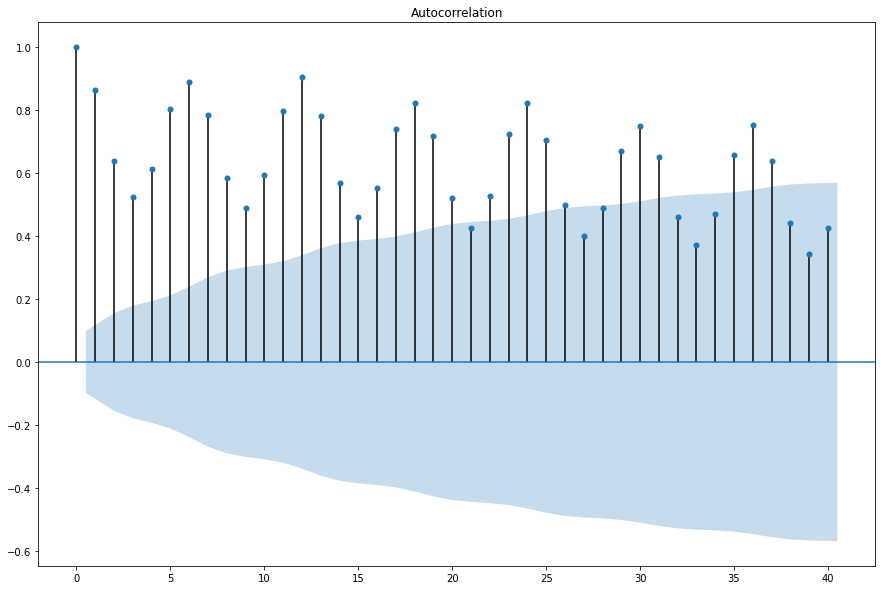

In [11]:
x = plot_acf(df, lags=40)
x.set_size_inches(15, 10, forward=True)
plt.show()

### Partial Autocorrelation Plot

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags. By examining the spikes at each lag we can determine whether they are significant or not. A significant spike will extend beyond the significant limits, which indicates that the correlation for that lag doesn't equal zero.

[API](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html)


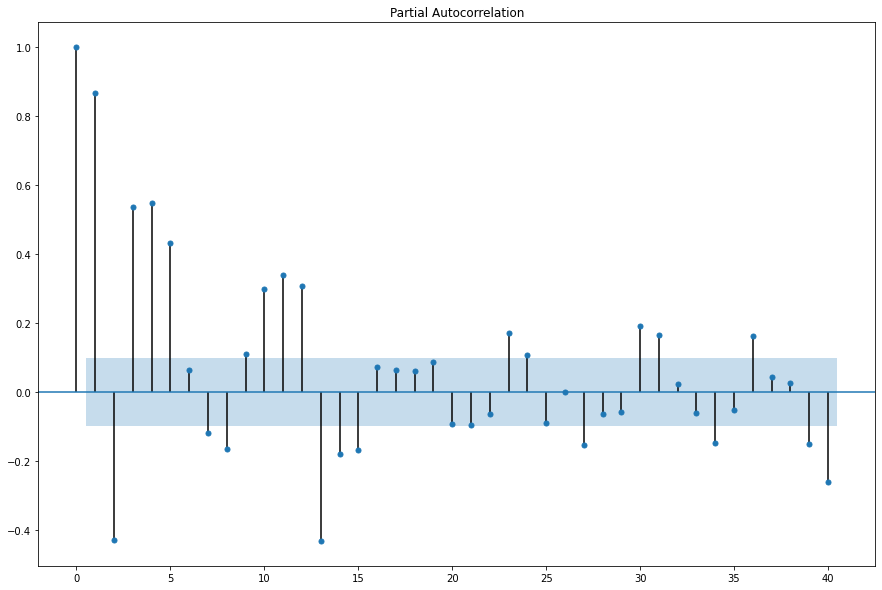

In [12]:
y = plot_pacf(df, lags=40)
y.set_size_inches(15, 10, forward=True)
plt.show()

### Data Splitting

Since we are using a univariate dataset, we can directly split our data into training and testing subsets. The first subset is utilized to fit/train the model. The second subset is used for prediction. The main motive is to estimate the performance of the model on new data.

In [13]:
size = int(len(df)*0.9)
df_train, df_test = df.iloc[:size], df.iloc[size:]

### Model

Simple Exponential smoothing is a time series forecasting method for univariate data that can be extended to support data with a systematic trend or seasonal component.It is a powerful forecasting method that may be used as an alternative to the popular Box-Jenkins ARIMA family of methods.

Exponential smoothing forecasting methods are similar in that a prediction is a weighted sum of past observations, but the model explicitly uses an exponentially decreasing weight for past observations.

#### Model Tuning Parameters

    1. endog: array_like
>The observed time-series process 

    2. initialization_method: str, optional
>Method for initialize the recursions
None defaults to the pre-0.12 behavior where initial values are passed as part of fit. If any of the other values are passed, then the initial values must also be set when constructing the model. If ‘known’ initialization is used, then initial_level must be passed, as well as initial_trend and initial_seasonal if applicable. Default is ‘estimated’. “legacy-heuristic uses the same values that were used in statsmodels 0.11 and earlier.

    3. initial_level: float, optional
>The initial level component. Required if estimation method is “known. If set using either “estimated or “heuristic this value is used. This allows one or more of the initial values to be set while deferring to the heuristic for others or estimating the unset parameters.

Refer to the official documentation at [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html) for more parameters and information

In [14]:
model=SimpleExpSmoothing(df[target])
result=model.fit()

### Model Summary

After fitting the training data into our Simple Exponential Smoothing and training it, we can take a look at a brief summary of our model by using the **summary()** function. The followings aspects are included in our model summary:

1. Basic Model Details: The first column of our summary table contains the basic details regarding our model such as: 
    
        a. Name of dependent variable    
        b. Model used along with parameters    
        c. Date and time of model deployment    
        d. Time Series sample used to train the model
    
        
2. Probablistic Statistical Measures: The second column gives the values of the probablistic measures obtained by our model:
    
       a. Number of observations
   
       b. Log-likelihood, which comes from Maximum Likelihood Estimation, a technique for finding or optimizing the
       parameters of a model in response to a training dataset.
   
       c. Standard Deviation of the innovations
   
       d. Akaike Information Criterion (AIC), which is derived from frequentist probability.
   
       e. Bayesian Information Criterion (BIC), which is derived from Bayesian probability.
   
       f. Hannan-Quinn Information Criterion (HQIC), which is an alternative to AIC and is derived using the log-likelihood and 
       the number of observartions.
   
   
   
3. Statistical Measures and Roots: The summary table also consists of certain other statistical measures such as z-value, standard error as well as the information on the characteristic roots of the model.

In [15]:
result.summary()

Dep. Variable:,endog,No. Observations:,397
Model:,SimpleExpSmoothing,SSE,23821.620
Optimized:,True,AIC,1629.482
Trend:,None,BIC,1637.450
Seasonal:,None,AICC,1629.584
Seasonal Periods:,None,Date:,"Sun, 12 Sep 2021"
Box-Cox:,False,Time:,16:11:23
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,72.505200,l.0,True


#### Simple Forecasting

In [16]:
df_train.tail()

,Value
DATE,
2014-05-01,92.1340
2014-06-01,101.8780
2014-07-01,108.5497
2014-08-01,108.1940
2014-09-01,100.4172


### Predictions

By specifying the start and end time for our predictions, we can easily predict the future points in our time series with the help of our model.

In [17]:
d = df.drop([target], axis = 1)

start_date = d.iloc[size].name
end_date = d.iloc[len(df)-1].name

df_pred = result.predict(start = start_date, end = end_date)
df_pred.head()

2014-10-01    100.4172
2014-11-01     92.3837
2014-12-01     99.7033
2015-01-01    109.3477
2015-02-01    120.2696
Freq: MS, dtype: float64

## Model Accuracy

We will use the three most popular metrics for model evaluation: Mean absolute error (MAE), Mean squared error (MSE), or Root mean squared error (RMSE).

In [18]:
test = df_test[target]
print("Mean Absolute Error {:.2f}".format(mean_absolute_error(test,df_pred)))
print("Mean Squared Error {:.2f}".format(mean_squared_error(test,df_pred)))
print("Root Mean Squared Error {:.2f}".format(np.sqrt(mean_squared_error(test,df_pred))))

Mean Absolute Error 8.57
Mean Squared Error 98.58
Root Mean Squared Error 9.93


## Predictions Plot

First we make use of plot to plot the predicted values returned by our model based on the test data.
After that we plot the actual test data to compare our predictions.

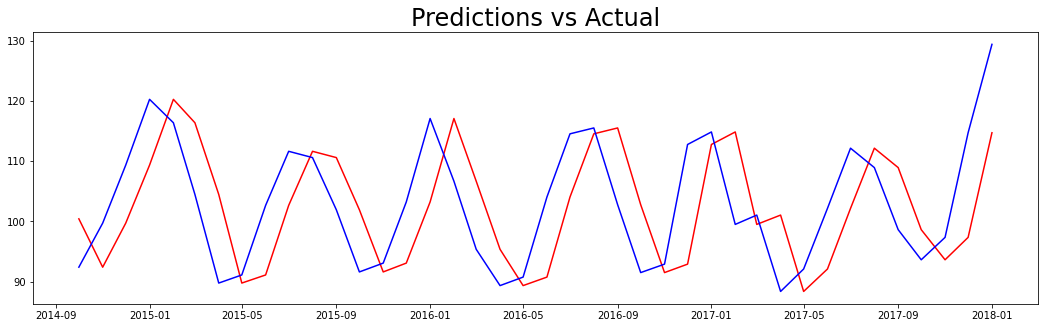

In [19]:
plt.figure(figsize=(18,5))
plt.plot(df_pred[start_date:end_date], color = "red")
plt.plot(df_test, color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.plot(fontsize="x-large")

plt.show()

#### Creator: Arpit Somani, Github: [Profile](https://github.com/arpitsomani8)